# Análise de dados

Neste exercício vamos explorar as potencialidades das bibliotecas Python `pandas` e `matplotlib` para mostrar como se desenvolve um processo de análise de dados.

A análise de dados é hoje uma ciência por si só e já aparecem anúncios de emprego à procuda de analistas de dados. 

Cada vez há mais dados e, pelo seu volume e complexidade, o seu tratamento exige bastantes conhecimentos, quer informáticos, quer matemáticos, quer estatísticos. 

Nos últimos anos as empresas foram acumulando dados e dados e enquanto os mesmos não forem tratados, não passm disso mesmo: são só dados. A análise de dados começa por extrair informação a partir dos dados, para depois gerar conhecimento a partir dessa informação. Esse conhecimento é que suporta a tomada de decisão.

## Dados, informação e conhecimento

É importante percebermos que há diferenças entre o que são apenas dados, informação e conhecimento. Acima do conhecimento podemos ainda distinguir a sabedoria, que é algo mais difícil de manipular em computador. A relação entre estes conceitos é conhecimda na informática como a [hierarquia DIKW](https://en.wikipedia.org/wiki/DIKW_pyramid).

Vamos usar um exemplo, apenas ilustrativo, para tentar explicar a diferença entre dados, informação e conhecimento (com base num caso real de uma cadeia de distribuição):

Dados: lista de todos os items comprados (imensa lista de faturas e linhas das faturas, em que cada linha é um item comprado)

Informação: perfis de consumo (que consiste em associar a um determinado consumidor (pelo NIF ou pelo cartão de cliente) aos items comprados). Realça-se que a informação resulta dos tratamento dos dados, como é claro neste exemplo.

Conhecimento: Com base no perfil de consumo, se o consumidor for mulher jovem e nas compras inclui um determinado suplemento de vitaminas, é provável que esteja grávida ou tenha alguma grávida na família. Pode-se começar a enviar anúncios de faldras passados 3 meses desde que começou a comprar os suplementos.

Como se vê, da mesma forma que se extrai o conhecimento exemplificado, extrai-se muitos outros, importantíssimos para o sucesso de uma cadeia de distribuição. Todas estas cadeias têm os seus analistas de dados e fazer este tipo de extração.

Neste exercício vamos à procura de dados sobre o processo de vacinação da COVID-19 e prever o número de vacinados daqui a uma semena, para Portugal.

### Obter as dados

Os dados podem ser procurados na internet. Há diversas fontes em cada país e sítios onde a informação de todos os países é agregada diariamente.

Vamos usar uma fonte de dados para todo so mundo e depois só usar os dados para Portugal. A vantagem é que podemos usar a mesma fonte e as mesmas técnicas para qualquer país.

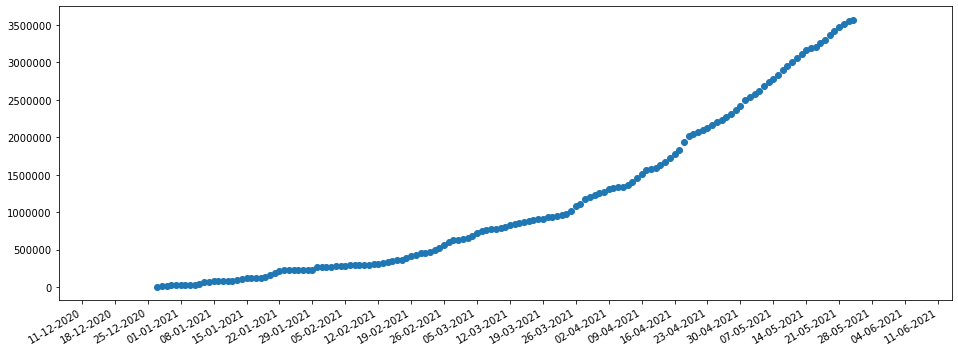

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pandas

vacinas = pandas.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
vacinaspt = vacinas[ vacinas.location == 'Portugal' ][ [ 'date', 'total_vaccinations', 'people_vaccinated' ] ]

x = vacinaspt.date
y = vacinaspt.people_vaccinated
plt.figure(figsize=(16,6))
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.scatter( x, y)
plt.gcf().autofmt_xdate()



Depois de termos filtrado os dados (linhas e colunas), apresentámos um gráfico para preceber a distribuição dos dados.

Vamos querer aproximar essa distribuição a uma função.

Para isso, vamos fazer um pequeno truque: vamois transforma o eixo dos x que está em datas para um número equivalente, para ser mais fácil fazer contas. Para transformar a data num númer, vamos substituir a data pelo número de dias desde a primeira data. Ou seja, no eixo dos x vamos ter o números dos dias desde que se começou a vacinar.

A primeira data de vacinação em Portugal é dada pela expressão seguinte:

In [37]:
vacinaspt.date.min()

'2020-12-27'

O número de dias desde esse primeiro dia até hoje é dado pela seguinte expressão:

In [42]:
from datetime import date, datetime

delta = date.today()-datetime.strptime( vacinaspt.date.min(), '%Y-%m-%d').date()
delta.days

150

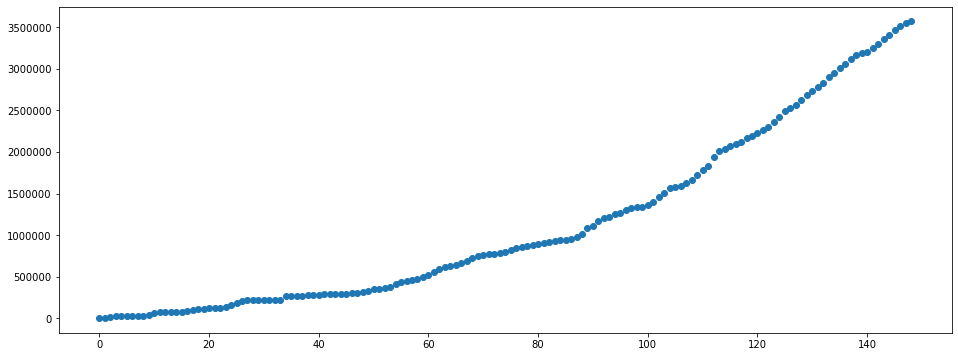

In [35]:
from datetime import date, datetime

d0 = datetime.strptime( vacinaspt.date.min(), '%Y-%m-%d').date()
vacinaspt['x'] = [ (datetime.strptime(d, '%Y-%m-%d').date()-d0).days for d in vacinaspt.date]

x = vacinaspt.x
y = vacinaspt.people_vaccinated
plt.figure(figsize=(16,6))
plt.scatter( x, y)

Tendo o eixo dos x devidamente transformado em números em vez de datas, podemos começar por tentar modelar os dados com uma regressão linear.

In [22]:
from scipy.stats import linregress
stats = linregress(x, y)

m = stats.slope
b = stats.intercept
coef = stats.rvalue

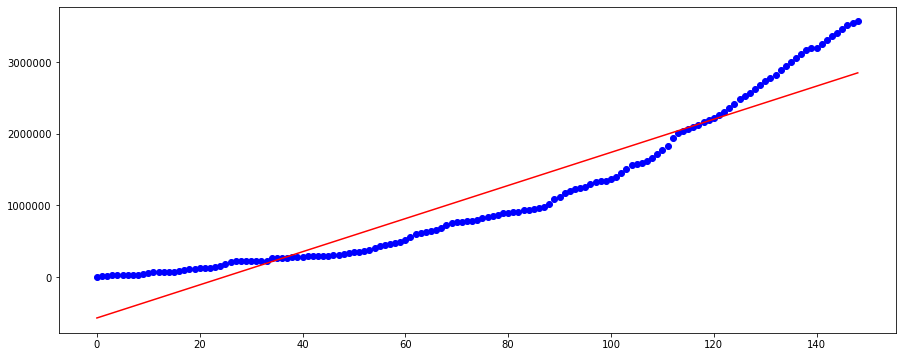

In [24]:
plt.figure(figsize=(15,6))
plt.scatter( x, y, color="blue")
plt.plot(x, m * x + b, color="red")

Como se pode ver pela representação gráfica, uma recta não é a melhor aproximação aos nosso dados. Para os nossos dados, teremos que usar uma função polinomial de ordem superior a 1.

Vamos usar alguns conceitas da [teoria da aproximação](https://en.wikipedia.org/wiki/Approximation_theory).

Em particular, vamos usar os polinómios de Chebyshev.

No primeiro exemplo, vamos usar um polinómio de Chebyshev de ordem 1 (`deg=1`) e vamos ver que o resultado é semelhante ao da regressão linear. Por isso mesmo, temos que usar uma ordem superior a 1.


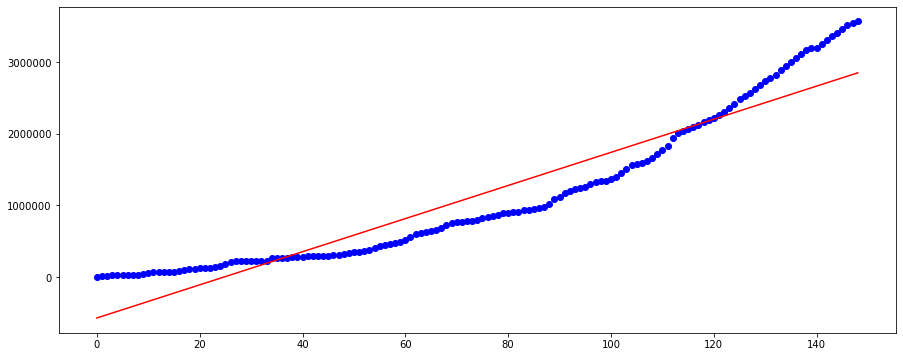

In [64]:
from numpy.polynomial import Chebyshev
c = Chebyshev.fit(x, y, deg=1)
xx, yy = c.linspace()

plt.figure(figsize=(15,6))
plt.scatter( x, y, color="blue")
# plt.plot(x, m * x + b, color="red")
plt.plot(xx, yy, color="red")

Experimentando com `deg=2` ou `deg=3` já se consegue uma boa aproximação.

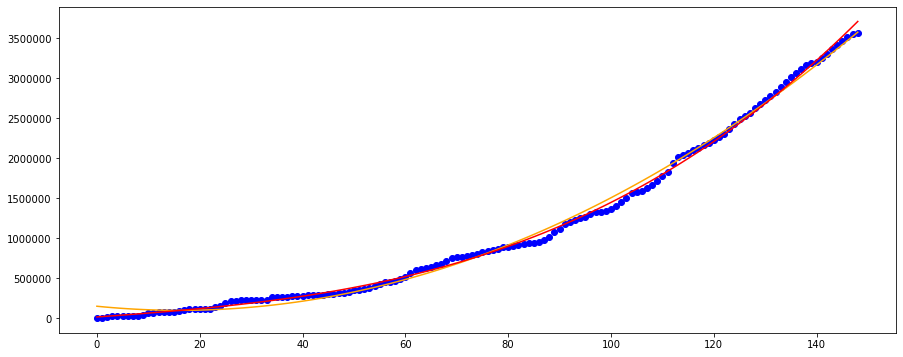

In [71]:
from numpy.polynomial import Chebyshev
c2 = Chebyshev.fit(x, y, deg=2)
xx2, yy2 = c2.linspace()
c3 = Chebyshev.fit(x, y, deg=3)
xx3, yy3 = c3.linspace()

plt.figure(figsize=(15,6))
plt.scatter( x, y, color="blue")
# plt.plot(x, m * x + b, color="red")
plt.plot(xx2, yy2, color="orange")
plt.plot(xx3, yy3, color="red")

Tento a(s) série(s) de Chebyshev calculada no passo anterior dada por `c2` ou `c3`, podemos calcular o valor da mesma para qualquer um dos dias.

Podemos comparar o valor real da vacinação do último dia com o valor modelado pela série:

In [57]:
vacinaspt[ vacinaspt.date == vacinaspt.date.max() ]['people_vaccinated']

16209    3567626.0
Name: people_vaccinated, dtype: float64

In [69]:
from datetime import timedelta
inicio = datetime.strptime( vacinaspt.date.min(), '%Y-%m-%d').date()
fim = datetime.strptime( vacinaspt.date.max(), '%Y-%m-%d').date()
c2((fim-inicio).days)

3573652.1750797806

Como se pode ver pelos resultados e pelo gráfico, os valores estimados pela série estão um pouco acima dos realmente verificados.

Por fim, vamos então estimar o número de pessoas vacinadas ao fim de mais uam semana.

In [72]:
from datetime import timedelta
inicio = datetime.strptime( vacinaspt.date.min(), '%Y-%m-%d').date()
fim = datetime.strptime( vacinaspt.date.max(), '%Y-%m-%d').date()
futuro = fim+timedelta(days=7)
# futuro = datetime.strptime( '2021-05-31', '%Y-%m-%d').date()
c2((futuro-inicio).days)

3951963.670220456

Concluído que está o exercício, poderemos estimar que, daqui a uma semana, no dia '2021-05-31' estima-se que estejam vacinados 4.172.654 pessoas em Portugal.